In [15]:
import pickle
import csv
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras.utils.training_utils import multi_gpu_model
from keras.models import model_from_json
from keras import metrics
from keras.optimizers import SGD
from keras import backend as K
import json
import os
import bcolz as bc
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
%matplotlib inline

In [4]:
# Generator method
def generator(x, y, batch_size):
    while(True):
        rand_keys = np.random.choice(x.shape[0], batch_size)
        yield x[rand_keys], y[rand_keys]

In [5]:
# Read data files
data_path = 'data/x_train_std/'
x_train = bc.open(data_path)
with open('data/y_train_std.pickle', 'rb') as f:
    y_train = pickle.load(f)
y_train = np.array(y_train, dtype=np.float32)
print(x_train.shape, y_train.shape)

(1338, 170, 284, 247, 8) (1338,)


In [6]:
# bc_features = bc.open('data/bc_features/')
# bc_features.shape

In [7]:
# with open('data/pdb2idx.pickle', 'rb') as f:
#     pdb2idx = pickle.load(f)
# len(pdb2idx)

In [8]:
# with open('data/idx2pdb.pickle', 'rb') as f:
#     idx2pdb = pickle.load(f)
# len(idx2pdb)

In [9]:
# non_trained_ids = [_id for _id in pdb2idx.values() if _id not in idx2pdb.keys()]
# len(non_trained_ids)

In [10]:
# len(trained_pdbs)

In [11]:
# Load the model
with open('new/test_cnn_model.json', 'r') as f:
    loaded_model = f.read()
model = model_from_json(loaded_model)
# model = multi_gpu_model(model, gpus=4)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 83, 140, 122, 64)  64064     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 41, 70, 61, 64)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 39, 68, 59, 128)   221312    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 19, 34, 29, 128)   0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 17, 32, 27, 256)   884992    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 8, 16, 13, 256)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 6, 14, 11, 512)    3539456   
__________

In [13]:
model = multi_gpu_model(model, gpus=2)

In [16]:
model.compile(optimizer=SGD(lr = 0.001),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [17]:
# Load the weights
model.load_weights('new/test_cnn_model_weights.h5')

### Evaluate the model

In [18]:
# Get some test data from training data and predict
batch_size = 5
x_test, y_test = next(generator(x_train, y_train, batch_size))
y_pred = model.predict(x_test)
print('Actual values: ', y_test)
print('Predicted data: ', y_pred.flatten())

Actual values:  [3.1  6.74 7.44 6.88 6.15]
Predicted data:  [6.254906  6.1303887 6.2578764 6.2205167 6.233172 ]


In [19]:
print("The mean of y_train ", np.mean(y_train))

The mean of y_train  6.47488


In [20]:
y_exp = []
y_predict = []

In [21]:
for _ in range(10):
    bx, y_ = next(generator(x_train, y_train, batch_size))
    y_p = model.predict(bx)
    y_predict = y_predict + y_p.tolist()
    y_exp = y_exp + y_.tolist()

In [22]:
r2 = r2_score(y_pred=y_predict, y_true=y_exp)
r2

0.0778020690339033

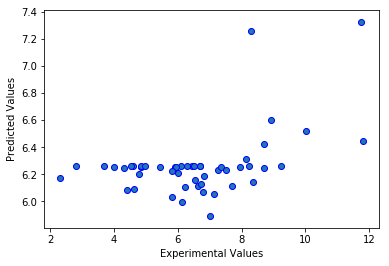

In [23]:
f = plt.figure()
plt.xlabel('Experimental Values')
plt.ylabel('Predicted Values')
plt.scatter(y_exp, y_predict, marker='o', edgecolors='b')
# plt.legend(['Binding Affinity'])
plt.show()

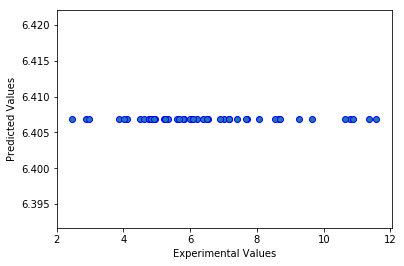

In [20]:
f = plt.figure()
plt.xlabel('Experimental Values')
plt.ylabel('Predicted Values')
plt.scatter(y_exp, y_predict, marker='o', edgecolors='b')
# plt.legend(['Binding Affinity'])
plt.show()

In [21]:
f.savefig('comparison.png')

### Training history

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
with open('new/test_history.pickle', 'rb') as f:
    history = pickle.load(f)

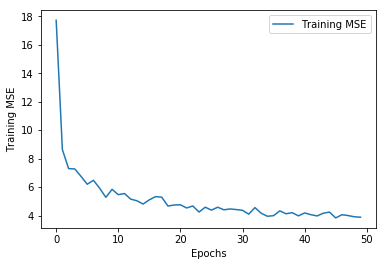

In [26]:
f2 = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Training MSE')
plt.plot(history['loss'], label='Training MSE')
plt.legend()
plt.show()

In [25]:
f2.savefig('training.png')